# CorrelAid X Challenge 2021 - Classifying tensions in social media data using NLP
Chapter Bremen X HH

### Libraries

In [59]:
!pip3 install transformers
import tensorflow as tf
import tensorflow_datasets as tfds

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from collections import Counter

from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data set
## 1.1. Get data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_raw = pd.read_csv("./drive/My Drive/Bert/phoenix_tensions.csv")
df_appendix = pd.read_csv("./drive/My Drive/Bert/phoenix_tensions_appendix.csv")

In [7]:
#df_raw = pd.read_csv("phoenix_tensions.csv")
#df_appendix = pd.read_csv("phoenix_tensions_appendix.csv")

In [8]:
COL_ORDER = df_raw.filter(like="is_").columns

## 1.2. Preprocessing

In [9]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              1644 non-null   int64  
 1   object_id                               1644 non-null   object 
 2   object_type                             1644 non-null   object 
 3   text                                    1644 non-null   object 
 4   is_economic_labour_tension              1644 non-null   float64
 5   economic_labour_tension_direction       128 non-null    object 
 6   is_political_tension                    1644 non-null   float64
 7   political_tension_direction             159 non-null    object 
 8   is_service_related_tension              1644 non-null   float64
 9   service_related_tension_direction       134 non-null    object 
 10  is_community_insecurity_tension         1644 non-null   floa

In [10]:
#Recode tensions as they have different categories 

tensions = [
    "economic_labour_tension_direction",
    "political_tension_direction",
    "service_related_tension_direction",
    "community_insecurity_tension_direction",
]

print("old categories\n")

for i in tensions:
    print(i)
    print(Counter(df_raw[i]))

print("\nnew categories\n")    

#define Categorical dtype for Tensions
cat_type = CategoricalDtype(categories=["decrease", "neutral", "increase"], ordered=True)

#recode tensions 
for i in tensions:
    df[i] = df[i].replace([' '], [np.nan])
    df[i] = df[i].replace(['Neutral', 'Neural', 'Nautral'], 'neutral')
    df[i] = df[i].replace(['Increase', 'ncrease'], 'increase')
    df[i] = df[i].replace(['Decrease'], 'decrease')
    df[i] = df[i].astype(cat_type) #make defined categorical dtype

    print(i)
    print(Counter(df[i]))

old categories

economic_labour_tension_direction
Counter({nan: 1516, 'Increase': 63, 'Neutral': 38, 'neutral': 18, 'increase': 6, 'decrease': 1, 'ncrease': 1, 'Nautral': 1})
political_tension_direction
Counter({nan: 1485, 'Increase': 85, 'Neutral': 47, 'neutral': 26, 'increase': 1})
service_related_tension_direction
Counter({nan: 1510, 'Increase': 64, 'Neutral': 37, 'neutral': 17, 'Decrease': 8, 'increase': 5, 'decrease': 2, ' ': 1})
community_insecurity_tension_direction
Counter({nan: 1596, 'Neutral': 27, 'Increase': 14, 'neutral': 5, 'increase': 1, 'Neural': 1})

new categories

economic_labour_tension_direction
Counter({nan: 1516, 'increase': 70, 'neutral': 57, 'decrease': 1})
political_tension_direction
Counter({nan: 1485, 'increase': 86, 'neutral': 73})
service_related_tension_direction
Counter({nan: 1511, 'increase': 69, 'neutral': 54, 'decrease': 10})
community_insecurity_tension_direction
Counter({nan: 1596, 'neutral': 33, 'increase': 15})


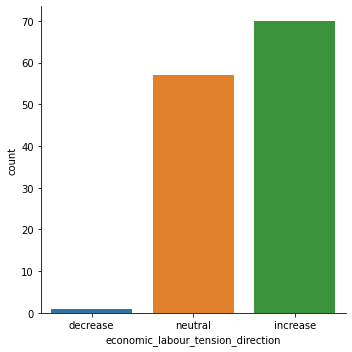

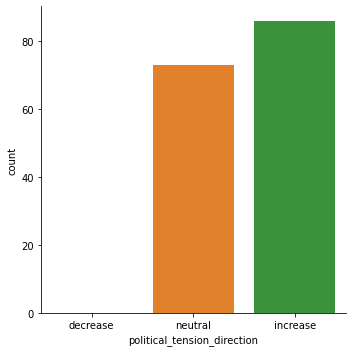

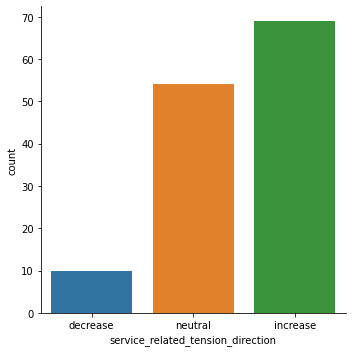

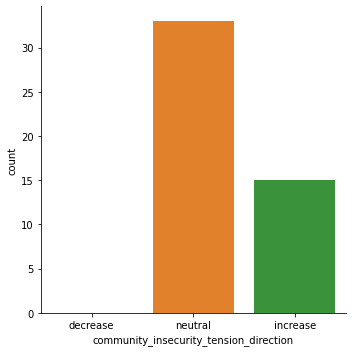

In [11]:
#Plot Tensions
for i in tensions:
    sns.catplot(x=i, kind="count", data=df)

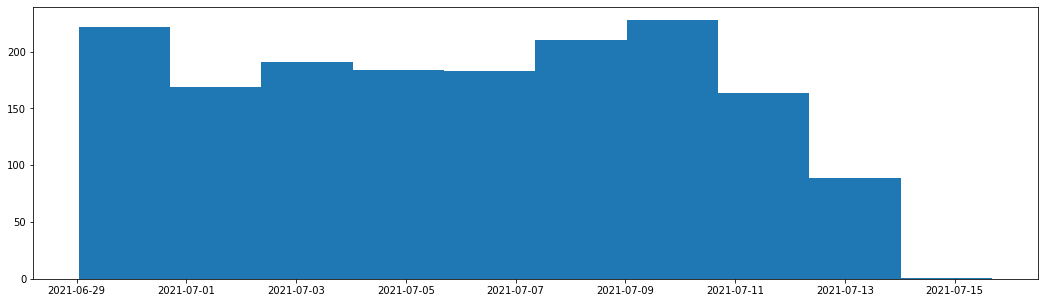

In [12]:
#Recode date to date format
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d %H:%M:%S')

#has 3 NA values (NaT)

#plot date
fig, ax = plt.subplots(figsize = (18, 5))
plt.hist(df["date"])
plt.show()

## 1.3. Dummies & Train_Test_Split

In [13]:
#Make dummies
#Na values will simply get 0 

df = pd.get_dummies(df, columns=["economic_labour_tension_direction", "political_tension_direction",
                            "service_related_tension_direction","community_insecurity_tension_direction"],
                          drop_first=False
              )

#Drop neutral dummies to only keep increase/ decrease
df = df[df.columns.drop(list(df.filter(regex='neutral')))]

In [14]:
#Train and Test Split 

train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=2021, 
)

In [15]:
train_df.to_csv("dummy_train.csv")
test_df.to_csv("dummy_test.csv")

In [16]:
len(train_df)

1315

# 2. BERT
## 2.1. Loading pretrained model

In [2]:
model = TFBertForSequenceClassification.from_pretrained("asafaya/bert-base-arabic", num_labels=8)
tokenizer = BertTokenizer.from_pretrained("asafaya/bert-base-arabic")

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/520M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

The random number seed for shuffling the training set should be used for maintaining shuffling in the case of Python runtime not keeping it's state between epochs (e.g. Google Colab):

In [3]:
seed_batching = 123

In [4]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  110617344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  6152      
Total params: 110,623,496
Trainable params: 110,623,496
Non-trainable params: 0
_________________________________________________________________


## 2.2. Creating of Training and Validation sets
Loading Anica's dataset:

In [5]:
"""For separate runs at Colab without preprocessing"""
from google.colab import drive
drive.mount('/content/drive')

df_train = pd.read_csv("./drive/My Drive/Bert/dummy_train.csv")
df_test = pd.read_csv("./drive/My Drive/Bert/dummy_test.csv")

Mounted at /content/drive


In [20]:
"""For case, if preprocessing was executed"""
df_train = train_df
df_test = test_df

In [6]:
df_train.head(1)

,Unnamed: 0,Unnamed: 0.1,object_id,object_type,text,is_economic_labour_tension,is_political_tension,is_service_related_tension,is_community_insecurity_tension,topics,matched_features,date,clean_text,economic_labour_tension_direction_decrease,economic_labour_tension_direction_increase,political_tension_direction_decrease,political_tension_direction_increase,service_related_tension_direction_decrease,service_related_tension_direction_increase,community_insecurity_tension_direction_decrease,community_insecurity_tension_direction_increase
0,1409,948,100053742612367-8c45f61602e550a3,facebook_post,تحذير من اندلاع الحرائق وتشديد على التبليغ فورًا,0.0,0.0,0.0,0.0,['other'],[None],2021-07-06 11:20:09,تحذير من اندلاع الحرايق وتشديد على التبليغ فورا,0,0,0,0,0,0,0,0


In [7]:
ID = 'object_id'
DATA_COLUMN = 'clean_text'
LABEL_COLUMNS = ['economic_labour_tension_direction_decrease',
       'economic_labour_tension_direction_increase',
       'political_tension_direction_decrease',
       'political_tension_direction_increase',
       'service_related_tension_direction_decrease',
       'service_related_tension_direction_increase',
       'community_insecurity_tension_direction_decrease',
       'community_insecurity_tension_direction_increase']

In [8]:
def convert_data_to_examples(df_input, data_columns, label_columns):
    input_examples = df_input.apply(lambda x:
                                    InputExample(guid=None,
                                                 text_a=x[data_columns],
                                                 text_b=None,
                                                 label=(x[label_columns]).values),
                                    axis=1)
    return input_examples


def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []
    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,  # Adds [CLS] and [SEP].
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding="max_length",
            truncation=True)
        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"], input_dict["token_type_ids"],
            input_dict['attention_mask'])
        features.append(InputFeatures(
            input_ids=input_ids, attention_mask=attention_mask,
            token_type_ids=token_type_ids, label=e.label))

    def gen():
        for f in features:
            yield ({
                "input_ids": f.input_ids,
                "attention_mask": f.attention_mask,
                "token_type_ids": f.token_type_ids, },
                f.label, )
    return tf.data.Dataset.from_generator(
        gen, ({
            "input_ids": tf.int32,
            "attention_mask": tf.int32,
            "token_type_ids": tf.int32},
            tf.int64),
        ({
            "input_ids": tf.TensorShape([None]),
            "attention_mask": tf.TensorShape([None]),
            "token_type_ids": tf.TensorShape([None]), },
            tf.TensorShape([8]), ), )   # 8 hard-coded here !!!

At the first step a model predicting review score based on the review text will be created. For training of the BERT model the dataset samples should be converted to the InputExample objects, containing

guid - unique id for the example (not used)
text_a (string) - the untokenized text of the first sequence
text_b (optional, string) - the untokenized text of the second sequence (not used)
label (optional, int) - The label of the example
and assembled to the TensorFlow datasets train_data and validation_data:

In [9]:
train_input_examples = convert_data_to_examples(
    df_train, DATA_COLUMN, LABEL_COLUMNS) 

validation_input_examples = convert_data_to_examples(
    df_test, DATA_COLUMN, LABEL_COLUMNS)

train_data = convert_examples_to_tf_dataset(
    list(train_input_examples), tokenizer)

train_data = train_data.shuffle(
    buffer_size=1000, seed=seed_batching).batch(32, drop_remainder=True)

validation_data = convert_examples_to_tf_dataset(
    list(validation_input_examples), tokenizer)
validation_data = validation_data.batch(32, drop_remainder=True)

## 2.3. Treating sample imbalance ????

## 2.4. Training the model
The actual model has been trained on the Google Colab free runtime. In order to feed the model with different training sets across the epochs seed_batching random seed should be changed. The variation of learning_rate parameter between ??? and ??? as well as gamma power from 1 to 4 did ??? affected validation accuracy significantly????. The ???? model was trained within ?? epochs, ?? epochs with ???? steps and the last epoch with ???? steps. The training step time for the given batch size was about ??? ms for P100 GPU and ???? ms for T4 GPU in full precision mode. The mixed precision mode give ??? ms per step on T4 GPU. The validation set accuracy along the epochs is slightly above ???%.

In [10]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [86]:
@tf.function
def macro_f1(y, y_hat, thresh=0.2):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [87]:
opt = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

model.compile(optimizer=opt, 
              loss=macro_soft_f1,
              metrics=[macro_f1])

#model.compile(optimizer=opt, 
#              loss=tf.keras.losses.BinaryCrossentropy(), 
#              metrics=[tf.keras.metrics.BinaryAccuracy()])

We need to use keras.metrics.BinaryAccuracy() for measuring the accuracy since it calculates how often predictions match binary labels.

As we are dealing with multi-label classification and true labels are encoded multi-hot, we need to compare pairwise (binary!): each element of prediction with the corresponding element of true labels.

See https://medium.com/deep-learning-with-keras/how-to-solve-multi-label-classification-problems-in-deep-learning-with-tensorflow-keras-7fb933243595

For soft-F1 see https://github.com/ashrefm/multi-label-soft-f1/blob/master/Multi-Label%20Image%20Classification%20in%20TensorFlow%202.0.ipynb

In [88]:
model.fit(train_data.repeat(), epochs=4, steps_per_epoch=100, validation_data=validation_data)

Epoch 1/4
100/100 [==============================] - 196s 2s/step - loss: 0.9646 - macro_f1: 0.0333 - val_loss: 0.9578 - val_macro_f1: 0.0413
Epoch 2/4
100/100 [==============================] - 162s 2s/step - loss: 0.9657 - macro_f1: 0.0336 - val_loss: 0.9566 - val_macro_f1: 0.0413
Epoch 3/4
100/100 [==============================] - 162s 2s/step - loss: 0.9626 - macro_f1: 0.0330 - val_loss: 0.9546 - val_macro_f1: 0.0270
Epoch 4/4
100/100 [==============================] - 162s 2s/step - loss: 0.9631 - macro_f1: 0.0286 - val_loss: 0.9565 - val_macro_f1: 0.0376


In [89]:
"""Batch prediction for validation data"""
tf_batch = tokenizer(df_test[DATA_COLUMN].tolist(), max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
predictions = tf.nn.softmax(tf_outputs[0], axis=-1)

y_true = df_test[LABEL_COLUMNS].to_numpy()             
                     
LABELS = LABEL_COLUMNS

#X_test = test["DATA_COLUMN"]
#predictions = model.predict(X_test, batch_size=1000)




In [90]:
my_threshold = 0.2  # hard-coded threshold !!!!!!!!!!!!!!!!

y_pred = []
for sample in predictions.numpy():
    y_pred.append([1 if i >= my_threshold else 0 for i in sample ])

y_pred = np.array(y_pred)
#y_pred[8]
#predictions.numpy()[8]

#df_predictions = pd.DataFrame(predictions.numpy())

#df_predictions
#y_true[8]
confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)

In [91]:
"""Classification report"""
print(classification_report(y_true, y_pred,target_names=LABEL_COLUMNS))

                                                 precision    recall  f1-score   support

     economic_labour_tension_direction_decrease       0.00      0.00      0.00         0
     economic_labour_tension_direction_increase       0.00      0.00      0.00        15
           political_tension_direction_decrease       0.00      0.00      0.00         0
           political_tension_direction_increase       0.06      1.00      0.12        21
     service_related_tension_direction_decrease       0.00      0.00      0.00         2
     service_related_tension_direction_increase       0.05      1.00      0.10        16
community_insecurity_tension_direction_decrease       0.00      0.00      0.00         0
community_insecurity_tension_direction_increase       0.00      0.00      0.00         5

                                      micro avg       0.06      0.63      0.10        59
                                      macro avg       0.01      0.25      0.03        59
                   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

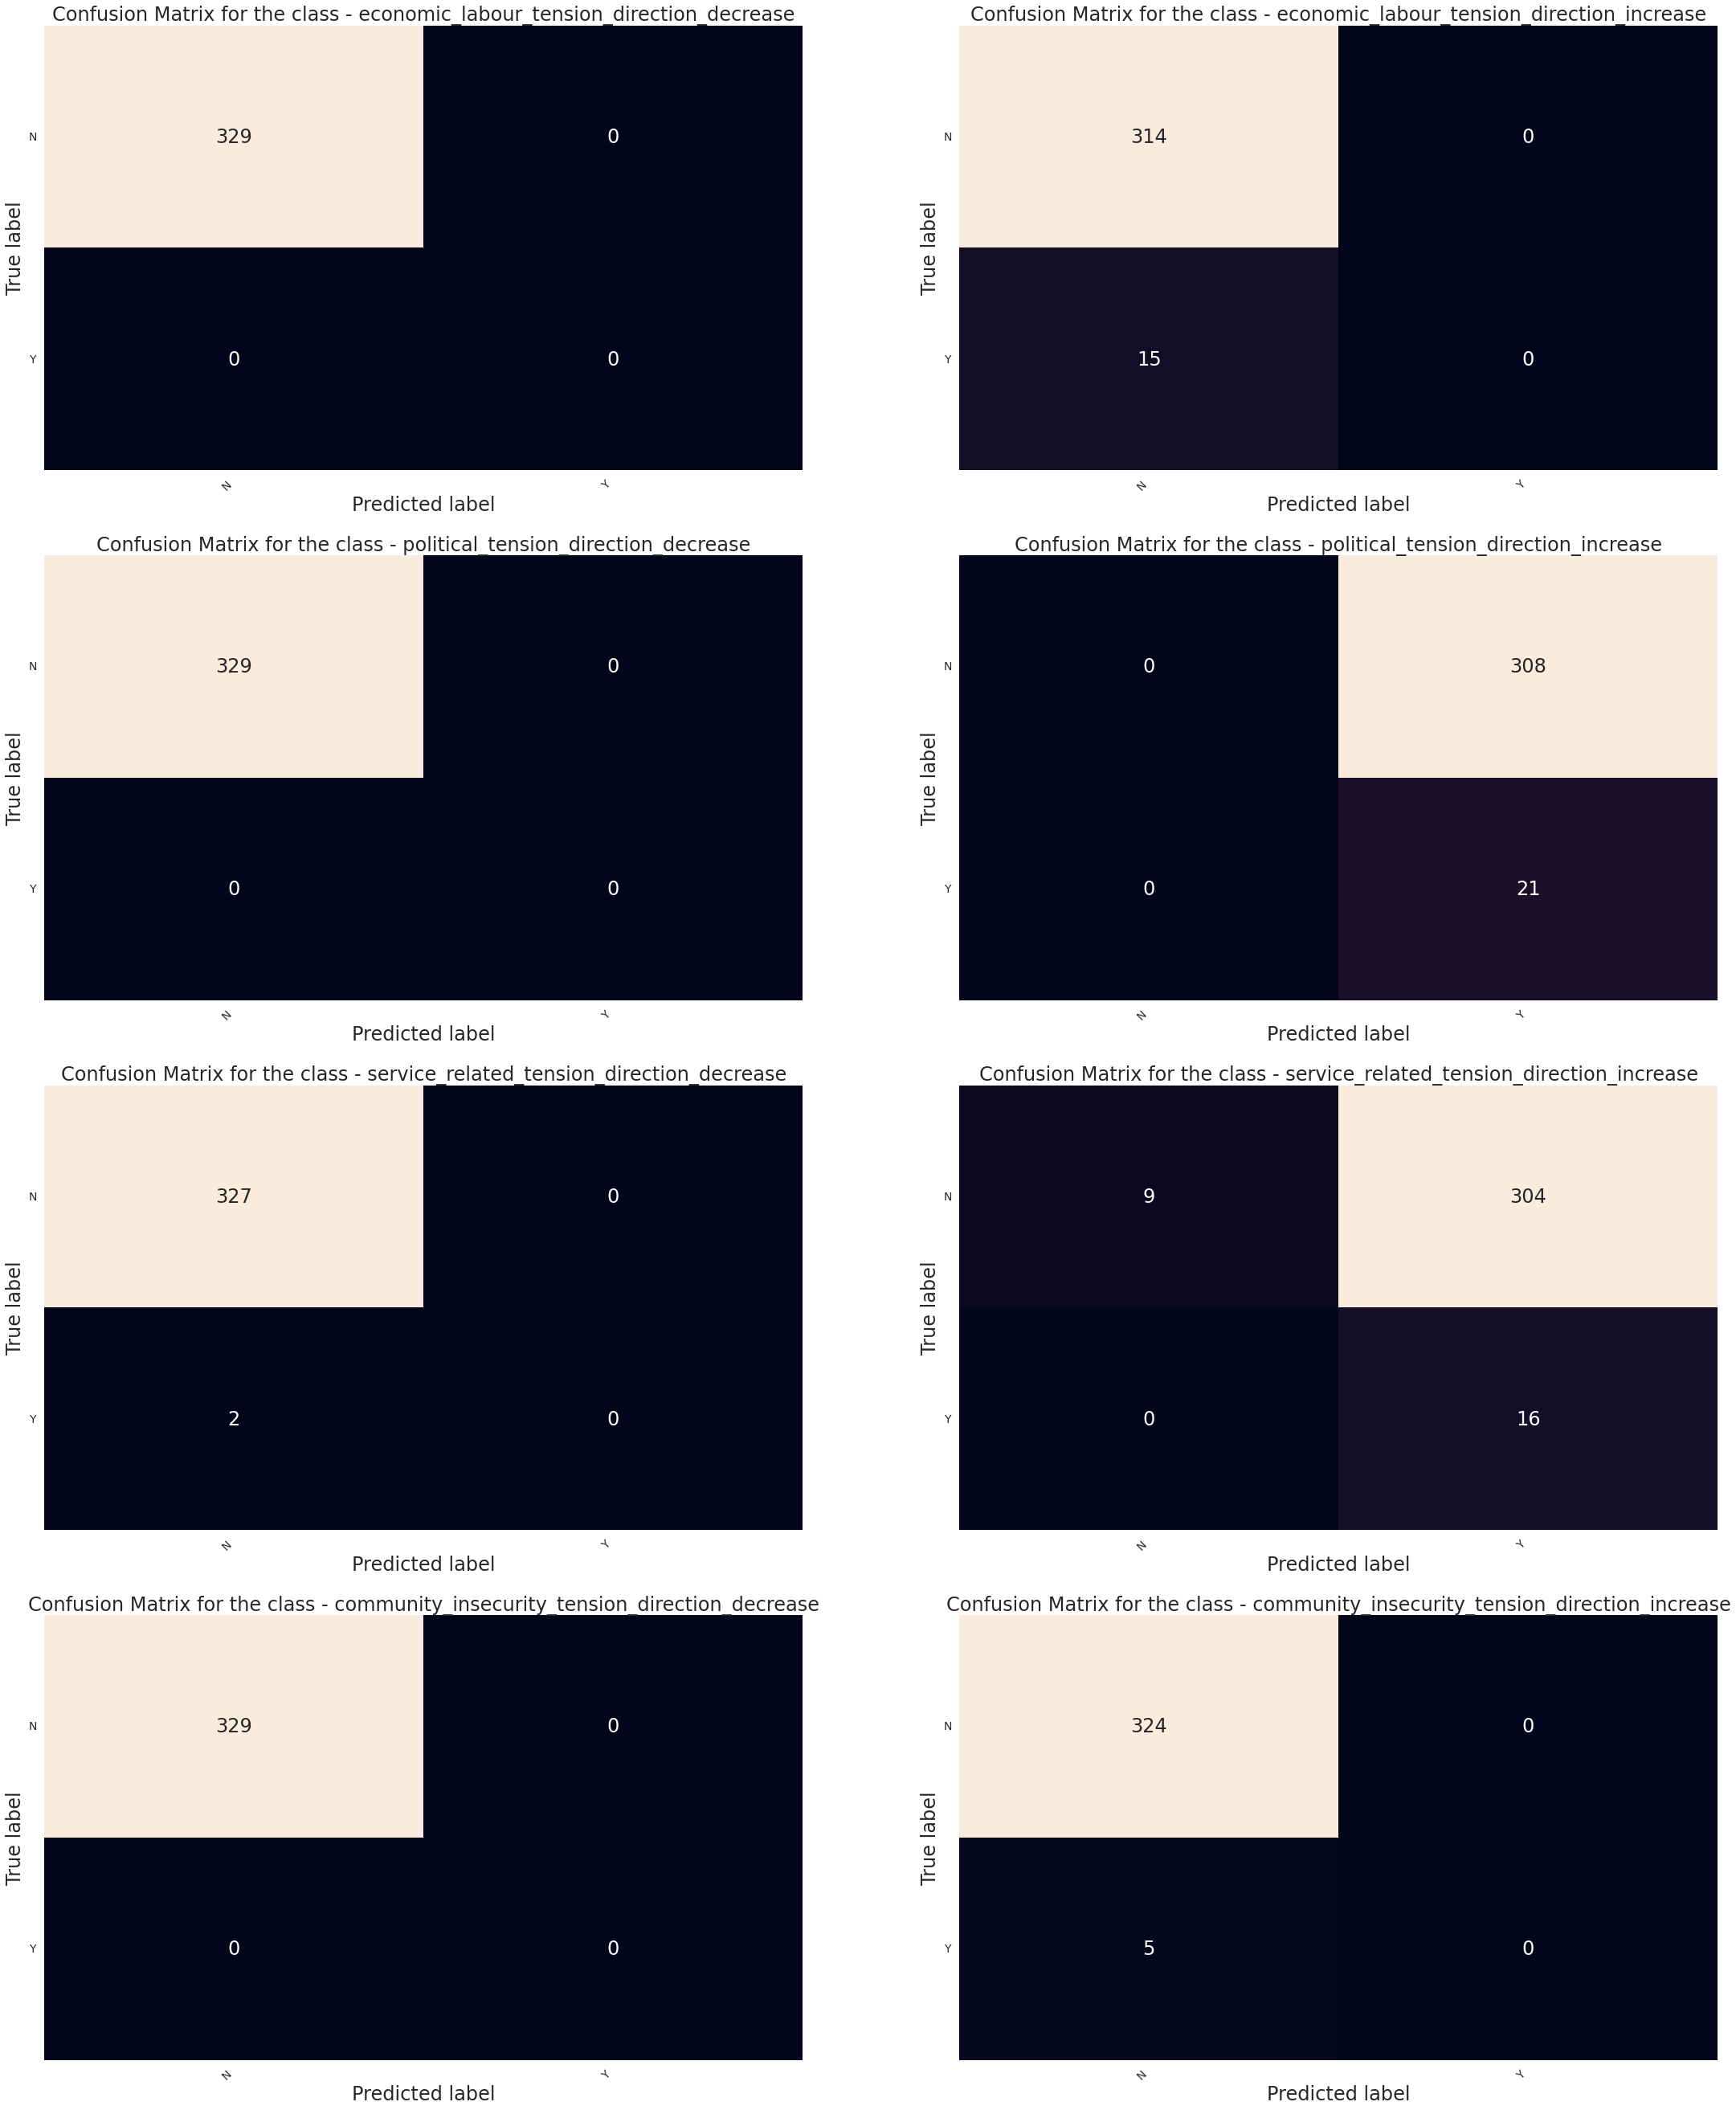

In [93]:
"""Visualization of multilabel confusion matrix"""

fig, ax = plt.subplots(4, 2, figsize=(32, 37))
    
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, LABEL_COLUMNS):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [94]:
"""Some auxiliary expressions to get an idea about the data structure"""
#df_train
#list(train_data.batch(1, drop_remainder=True))
#train_input_examples
#train_input_examples[1]

'Some auxiliary expressions to get an idea about the data structure'

## Baseline model using the annotations from the training data

This is quite horribly written and has a double loop in the predict which makes it slow so 
should probably be cleaned up etc

In [ ]:
df_annotations = pd.merge(train_df, df_appendix, on="object_id")

In [ ]:
TENSIONS = [
    "economic_labour_tension",
    "political_tension",
    "service_related_tension",
    "community_insecurity_tension",
]

all_feats = []
for tension in TENSIONS:
    feats = df_annotations[~df_annotations[f"{tension}_features"].isnull()][f"{tension}_features"]
    if len(feats) > 0:
        feats = pd.DataFrame({"feature": feats.str.split(",").explode()})
        feats["tension"] = tension
        all_feats.append(feats)
feats = pd.concat(all_feats, ignore_index=True, axis=0)
feats = {f["feature"]: f["tension"] for _, f in feats.iterrows()}


class Baseline(BaseEstimator, ClassifierMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        predictions = []
        for _, row in X.iterrows():
            out = {f"is_{t}": False for t in TENSIONS}
            for feat, tension in self.features.items():
                if feat in row["text"]:
                    out[f"is_{tension}"] = True
            predictions.append(out)
        return pd.DataFrame(predictions)[COL_ORDER].values

In [ ]:
def test(model, df):
    preds = model.predict(df)
    return metrics.f1_score(df[COL_ORDER].values, preds, average="macro")

In [ ]:
model = Baseline(feats)

test(model, train_df), test(model, test_df)

(0.08444991747911457, 0.0)

## Quick and dirty Random Forest classifier using the topics

In [ ]:
class CategoricalColumns(BaseEstimator, TransformerMixin):
    """CategoricalColumns is a quick and dirty One Hot Encoder transformer for the topics column."""
    def fit(self, df, y=None):
        topics = self._to_array(df["topics"])
        columns = topics.explode().unique()
        self.columns = [c.strip() for c in columns]
        return self
        
    def transform(self, df):
        out = {}
        for col in self.columns:
            out[col] = df["topics"].str.contains(col).astype(int)
        return pd.DataFrame(out)
        
    def _to_array(self, series):
        """Clean up a series to """
        remove = ["[", "]", "'"]
        for char in remove:
            series = series.str.replace(char, "", regex=False)
        return series.str.split(",")

In [ ]:
#CategoricalColumns returns this one-hot encoding.
CategoricalColumns().fit_transform(train_df)

,other,lebanese army/security forces,religious figure,covid / vaccination,beirut,economic collapse,education,foreign countries,lebanese revolution,north lebanon,...,occupied palestine,false news,call for protest,aid,external affairs/diplomacy,offensive language,international organizations / un,south lebanon,lebanese judiciary,asad regime
1409,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
963,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1450,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1174,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
452,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1152,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1365,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
forest = RandomForestClassifier(random_state=2021, class_weight="balanced")
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

model = Pipeline(
    [
        ("categories", CategoricalColumns()),
        ("random_forest", multi_target_forest)
    ]
)

model = model.fit(train_df, train_df[COL_ORDER].values)

test(model, train_df), test(model, test_df)

(0.23948309102198564, 0.20484195032733407)